In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, solve_ivp, fixed_quad, simpson
from scipy.special import kn
import astropy.constants as ct
import pandas as pd
from scipy.optimize import newton,curve_fit
from scipy.interpolate import interp1d
from scipy.differentiate import derivative

In [2]:
# Constants

vev = 246 # GeV - Higgs VEV
m_h = 125.2 # GeV - Higgs mass
Gamma_h = 4.07e-3 # GeV - total Higgs decay width
M_W = 80.3692 # GeV - W boson mass
M_Z = 91.188 # GeV - Z boson mass

m_e = 0.511e-3 # GeV - electron mass
m_muon = 105.66e-3 # GeV - muon mass
m_tau = 1.77693 # GeV - tau mass
m_u = 2.16e-3 # GeV - up mass
m_d = 4.7e-3 # GeV - down mass
m_c = 1.273 # GeV - charm mass
m_s = 93.5e-3 # GeV - strange mass
m_t = 172.57 # GeV - top mass
m_b = 4.183 # GeV - bottom mass

M_V = [M_W, M_Z]
M_f = [m_e,m_muon,m_tau,m_u,m_d,m_c,m_s,m_t,m_b]
n_cs = [1,1,1,3,3,3,3,3,3]

c_V = [1,1/2]

g_V = 3
g_f = 2

# C = 0.349 # no sé qué es esto
C = 1 - 5.792e-1 -6.240e-2 - 2.165e-4 - 2.876e-4

gstar = 106.75
MP = 2.4e18
T0 = 2.725*ct.k_B.value/ct.e.value*1e-9
gstars0 = 3.91
gstar0 = 3.38
s0 = 2*np.pi**2/45*gstars0*T0**3
rhoc0 = 4.78658e-5*1e6*ct.c.value**3*ct.hbar.value**3/ct.e.value**3*(1e-9)**4 # GeV⁴
gS = 1

s0mo = 2.8912e9*(ct.c.value/ct.hbar.value*ct.e.value*1e-9)**(-3)
rhoc0mo = 10.537*(ct.c.value/ct.hbar.value*ct.e.value*1e-9)**(-3)

In [3]:
# Relativistic degrees of freedom
rdof = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/Trabajo_de_grado/refs/heads/main/FIMP_fermion/rdof.csv')
rdof.loc[250,'Temp'] = T0
rdof['lnTemp'] = np.log(rdof['Temp'])
rdof['lnheff'] = np.log(rdof['g_s'])

In [4]:
# SM particles
SM_particles = pd.DataFrame(index=['h','W','Z','e','mu','tau','u','d','c','s','t','b'])
SM_particles['mass'] = np.array([m_h,]+M_V+M_f)
SM_particles['spin'] = np.array([0,1,1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
SM_particles['n_c'] = np.array([1,1,1,1,1,1,3,3,3,3,3,3])
SM_particles['dof'] = 2*SM_particles['spin']+1
SM_particles['antiparticle'] = np.array([0.5,1,0.5,1,1,1,1,1,1,1,1,1])
SM_particles['name'] = np.array(['Higgs','W± boson','Z0 boson','electron','muon','tau','up quark','down quark','charm quark','strange quark','top quark','bottom quark'])

In [5]:
# RDOF equations
heff = interp1d(rdof['Temp'][::-1],rdof['g_s'][::-1],bounds_error=False,fill_value=(rdof['g_s'].values[-1],rdof['g_s'].values[0]))
geff = interp1d(rdof['Temp'][::-1],rdof['g_rho'][::-1],bounds_error=False,fill_value=(rdof['g_rho'].values[-1],rdof['g_rho'].values[0]))
lnheff = interp1d(rdof['lnTemp'][::-1],rdof['lnheff'][::-1],bounds_error=False,fill_value=(rdof['lnheff'].values[-1],rdof['lnheff'].values[0]))
der = derivative(lnheff,rdof['lnTemp']).df
dlnheffdlnT = interp1d(rdof['lnTemp'][::-1],der[::-1],bounds_error=False,fill_value=(der[-1],der[0]))

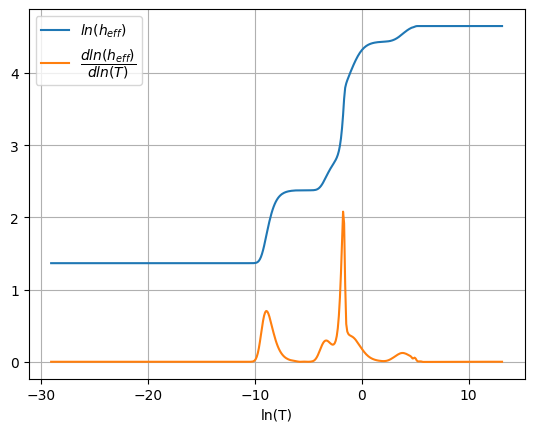

In [6]:
# Graph of RDOF
der = derivative(lnheff,rdof['lnTemp']).df

plt.plot(rdof['lnTemp'],rdof['lnheff'],label=r'$ln(h_{eff})$')
plt.plot(rdof['lnTemp'],dlnheffdlnT(rdof['lnTemp']),label=r'$\dfrac{dln(h_{eff})}{dln(T)}$')
plt.xlabel('ln(T)')
plt.grid()
plt.legend()
plt.show()

In [7]:
# Sigma
def sigma(w,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        if M_S<=M*np.tan(w)**0.5:
            A_ = g**-2*lambda_HS**2/(128*M**2*np.pi*np.tan(w))
            B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5
            C_ = (lambda_HS+3*M/(4*M*np.tan(w)-M+1j*Gamma_h)-2*vev**2*lambda_HS/(2*M**2*np.tan(w)-M**2))
            return (A_*B_*np.abs(C_)**2)
        else:
            return 0
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        if M_S<=M*np.tan(w)**0.5:
            A_ = g**-2*lambda_HS**2*M**2/(32*np.pi*np.tan(w))
            B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5
            C_ = (4*np.tan(w)**2-4*np.tan(w)+3)/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
            return (A_*B_*C_)
        else:
            return 0
    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']
        if M_S<=M*np.tan(w)**0.5:
            A_ = g**-2*lambda_HS**2*M**2*n/(16*np.pi*np.tan(w))
            B_ = ((np.tan(w)-M_S**2/M**2)*(np.tan(w)-1))**0.5
            C_ = 1/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
            return (A_*B_*C_)
        else:
            return 0
    
def Gamma_hSS(lambda_HS,M_S):
    if M_S < m_h/2:
        return lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2)**0.5
    else:
        return 0
    
sigma = np.vectorize(sigma)
Gamma_hSS = np.vectorize(Gamma_hSS)


In [8]:
# Sigma(s)
def sigma_s(s,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        A_ = g**-2*lambda_HS**2/(32*np.pi*s)
        B_ = ((s-4*M_S**2)/(s-4*M**2)+0j)**0.5
        C_ = (lambda_HS+3*M/(s-M**2+1j*M*Gamma_h)-4*vev**2*lambda_HS/(s-2*M**2))
        return (A_*B_*np.abs(C_)**2).real
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        A_ = g**-2*lambda_HS**2/(32*np.pi*s)
        B_ = ((s-4*M_S**2)/(s-4*M**2)+0j)**0.5
        C_ = (s**2-4*s*M**2+12*M**4)/((s-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_).real
    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']
        A_ = g**-2*lambda_HS**2*n/(16*np.pi*s)
        B_ = ((s-4*M_S**2)*(s-4*M**2)+0j)**0.5
        C_ = 1/((s-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_).real

def Gamma_hSS(lambda_HS,M_S):
    return (lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2+0j)**0.5).real

sigma_s = np.vectorize(sigma_s)
Gamma_hSS = np.vectorize(Gamma_hSS)

In [9]:
# Sigma (taking the real part of roots)
def sigma_RE(w,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        
        A_ = g**-2*lambda_HS**2/(128*M**2*np.pi*np.tan(w))
        B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1)+0j)**0.5
        C_ = (lambda_HS+3*M/(4*M*np.tan(w)-M+1j*Gamma_h)-2*vev**2*lambda_HS/(2*M**2*np.tan(w)-M**2))
        return (A_*B_*np.abs(C_)**2).real
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']

        A_ = g**-2*lambda_HS**2*M**2/(32*np.pi*np.tan(w))
        B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1)+0j)**0.5
        C_ = (4*np.tan(w)**2-4*np.tan(w)+3)/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_).real

    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']

        A_ = g**-2*lambda_HS**2*M**2*n/(16*np.pi*np.tan(w))
        B_ = ((np.tan(w)-M_S**2/M**2)*(np.tan(w)-1)+0j)**0.5
        C_ = 1/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_).real
    
def Gamma_hSS_RE(lambda_HS,M_S):
    return lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2+0j)**0.5


In [10]:
# Sigma (taking the real part of roots)
def sigma_abs(w,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        
        A_ = g**-2*lambda_HS**2/(128*M**2*np.pi*np.tan(w))
        B_ = (np.abs((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1)))**0.5
        C_ = (lambda_HS+3*M/(4*M*np.tan(w)-M+1j*Gamma_h)-2*vev**2*lambda_HS/(2*M**2*np.tan(w)-M**2))
        return (A_*B_*np.abs(C_)**2)
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']

        A_ = g**-2*lambda_HS**2*M**2/(32*np.pi*np.tan(w))
        B_ = (np.abs((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1)))**0.5
        C_ = (4*np.tan(w)**2-4*np.tan(w)+3)/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_)

    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']

        A_ = g**-2*lambda_HS**2*M**2*n/(16*np.pi*np.tan(w))
        B_ = (np.abs((np.tan(w)-M_S**2/M**2)*(np.tan(w)-1)))**0.5
        C_ = 1/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_)
    
def Gamma_hSS_abs(lambda_HS,M_S):
    return lambda_HS**2*vev**2/(32*np.pi*m_h)*(np.abs(1-4*M_S**2/m_h**2))**0.5


In [20]:
# Omegah2
def Omegah2(M_S,lambda_HS,TR,channel):
    def Boltz_eq(x):
        # HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
        # sMS = 2*np.pi**2/45*gstars0*M_S**3
        HMS = (np.pi**2*geff(M_S/x)/90)**0.5*M_S**2/MP
        sMS = 2*np.pi**2/45*heff(M_S/x)*M_S**3
        HMS = HMS/(1+(1/3)*dlnheffdlnT(np.log(M_S/x)))
        ws = np.linspace(np.pi/4+1e-5,np.pi/2-1e-5,100000)
        if channel == 'all':
            suma = 0
            for part in SM_particles.index:
                M = SM_particles.loc[part]['mass']
                g = SM_particles.loc[part]['dof']
                integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
                res = simpson(integrand(ws),ws)
                suma += (g**2/np.pi**4)*M_S*M**5/x*res
        
            return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        elif channel == 'decay':
            return x**4/(HMS*sMS)*(C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        else:
            M = SM_particles.loc[channel]['mass']
            g = SM_particles.loc[channel]['dof']
            n = SM_particles.loc[channel]['n_c']
            cx = SM_particles.loc[channel]['antiparticle']
            integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,channel)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
            res = simpson(integrand(ws),ws)
            term = ((g*n)**2*cx/np.pi**4)*M_S*M**5/x*res
            return x**4/(HMS*sMS)*term
    xR = M_S/TR
    x0 = M_S/T0
    xs = np.logspace(np.log10(xR),np.log10(x0),100000)
    Y = simpson(Boltz_eq(xs),xs)
    #return Y
    return s0mo*M_S*Y/rhoc0mo

Omegah2 = np.vectorize(Omegah2)

In [21]:
Omegah2(1,1e-11,1e6,'h')

array(2.91959152e+57)

In [18]:
# Omegah2 for sigma_RE
def Omegah2_v2(M_S,lambda_HS,TR,channel):
    def Boltz_eq(x):
        # HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
        # sMS = 2*np.pi**2/45*gstars0*M_S**3
        HMS = (np.pi**2*geff(M_S/x)/90)**0.5*M_S**2/MP
        sMS = 2*np.pi**2/45*heff(M_S/x)*M_S**3
        HMS = HMS/(1+(1/3)*dlnheffdlnT(np.log(M_S/x)))
        if channel == 'all':
            suma = 0
            for part in SM_particles.index:
                M = SM_particles.loc[part]['mass']
                g = SM_particles.loc[part]['dof']
                integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_abs(w,M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
                res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5,limit=100,epsabs=1e-12)[0]
                suma += (g**2/np.pi**4)*M_S*M**5/x*res
        
            return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS_abs(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        elif channel == 'decay':
            return x**4/(HMS*sMS)*(C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS_abs(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        else:
            M = SM_particles.loc[channel]['mass']
            g = SM_particles.loc[channel]['dof']
            n = SM_particles.loc[channel]['n_c']
            cx = SM_particles.loc[channel]['antiparticle']
            integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_abs(w,M_S,lambda_HS,channel)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
            res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5,limit=100,epsabs=1e-12)[0]
            term = ((g*n)**2*cx/np.pi**4)*M_S*M**5/x*res
            return x**4/(HMS*sMS)*term
    x0 = M_S/TR
    Y = quad(Boltz_eq,x0,np.inf,limit=100)[0]
    #return Y
    return s0mo*M_S*Y/rhoc0mo

Omegah2_v2 = np.vectorize(Omegah2_v2)

In [19]:
Omegah2_v2(1,1e-11,1e6,'h')

array(2.12665811e-06)

In [13]:
# Parameter space
mm = np.logspace(0,4)
ll = np.logspace(-13,-10,10)
MM, LL = np.meshgrid(mm,ll)

KeyboardInterrupt: 

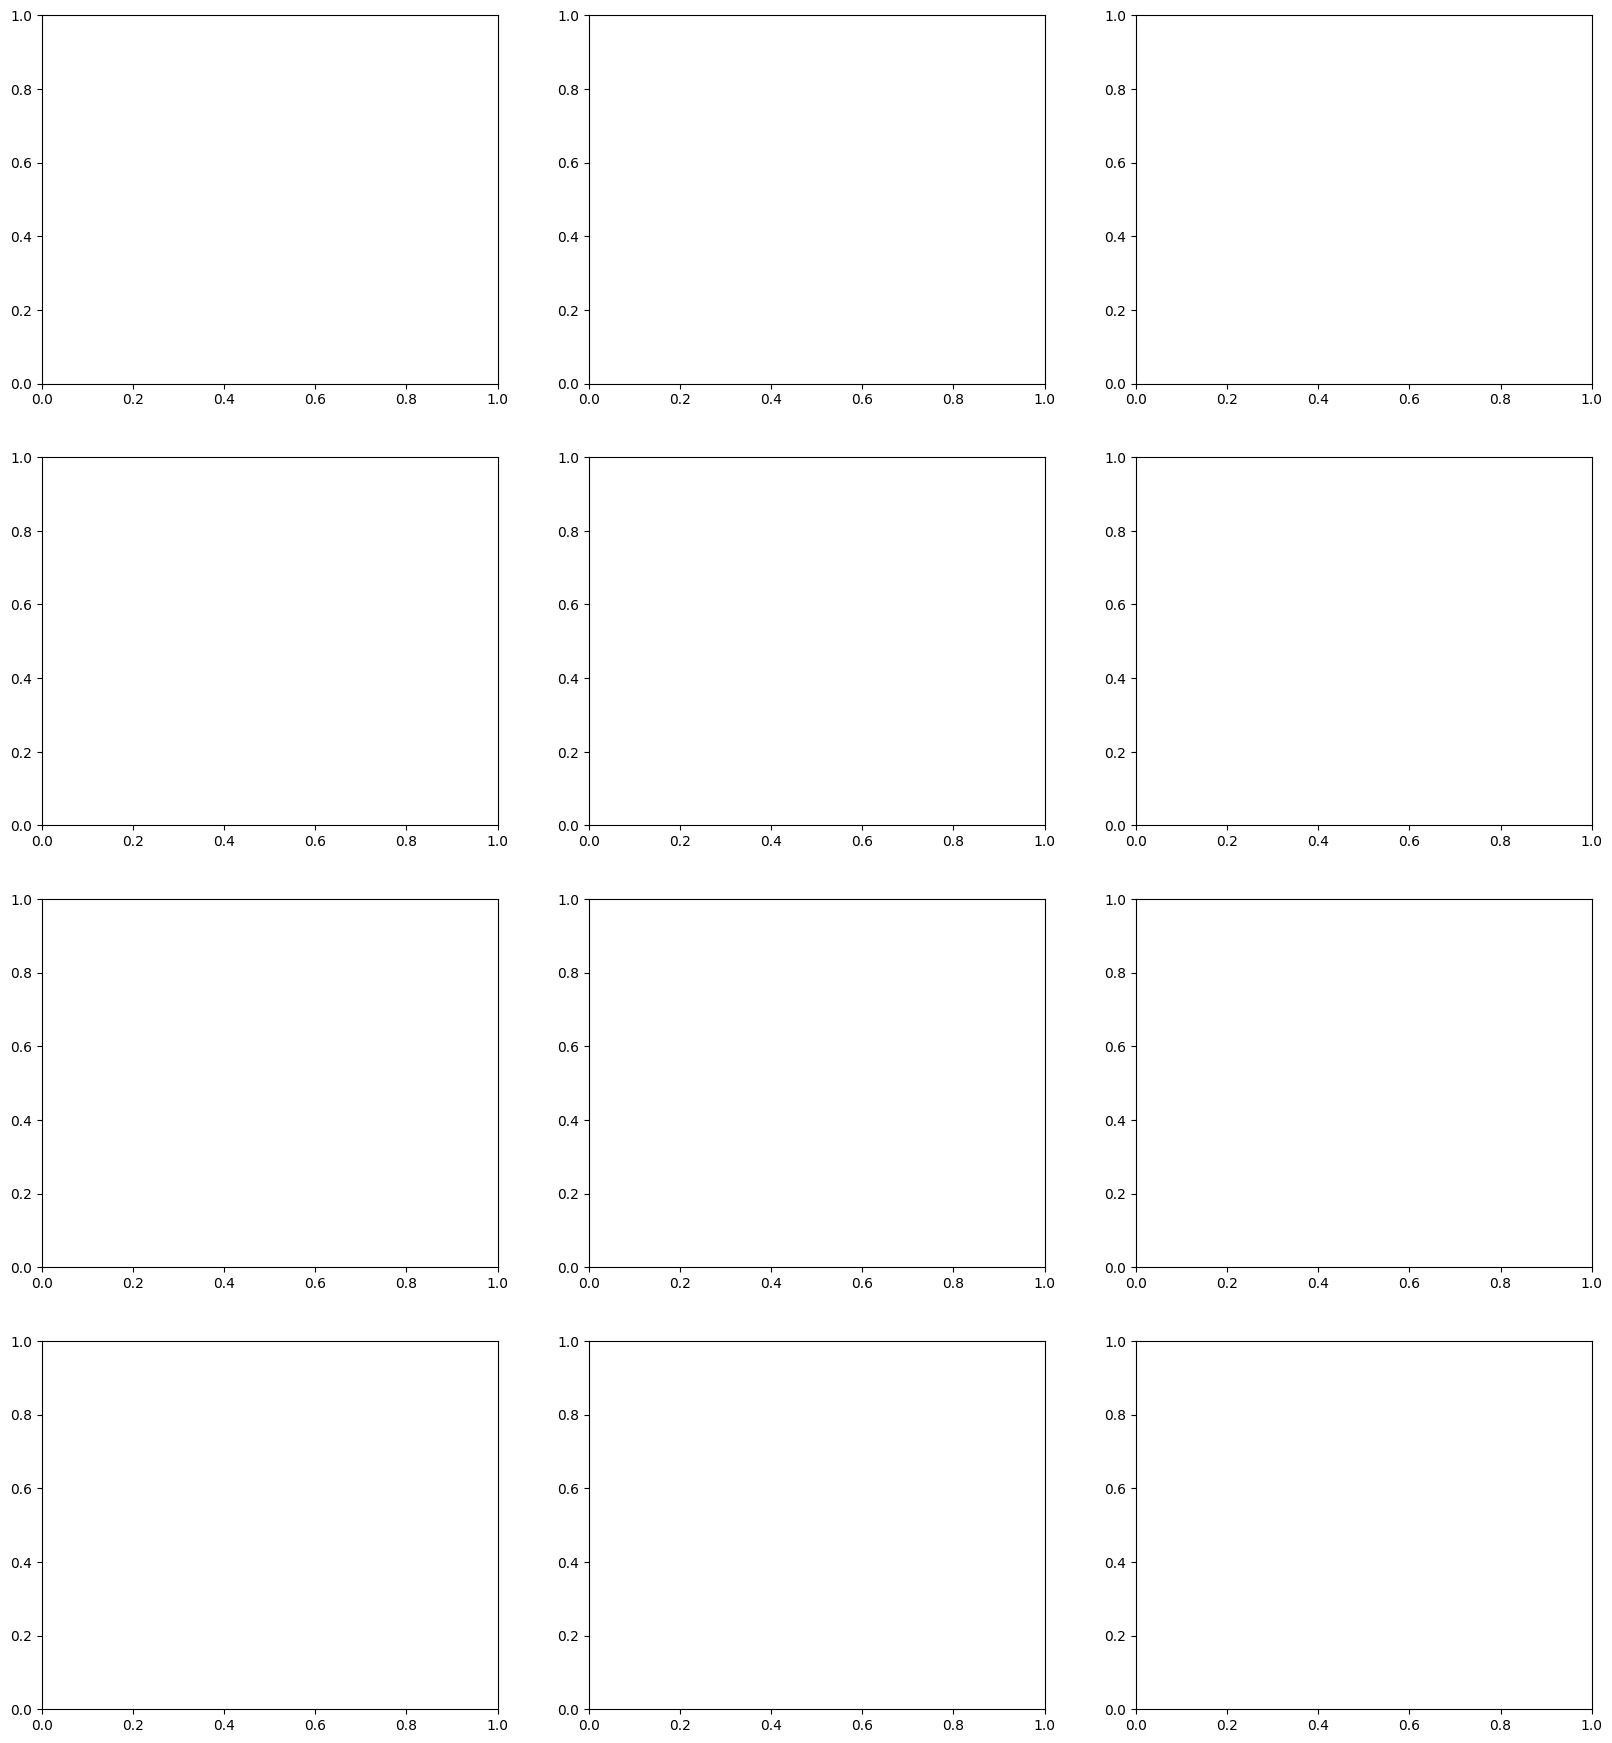

In [27]:
# Contours of abundance for Omegah2
fig, ax = plt.subplots(4,3,figsize=(20,22))
for i,part in enumerate(SM_particles.index):
    OO = Omegah2(MM,LL,1e12,part)
    CS = ax[i//3,i%3].contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)
    CSl = ax[i//3,i%3].contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
    ax[i//3,i%3].vlines(np.log10(SM_particles.loc[part]['mass']),-13,-10)
    cbar = fig.colorbar(CS)
    cbar.add_lines(CSl)
    ax[i//3,i%3].set(title=SM_particles.loc[part]['name'])
    print(SM_particles.loc[part]['name'] + ' completed')

/tmp/ipykernel_11618/1570270071.py:5: RuntimeWarning: divide by zero encountered in log10
  CS = ax[i//3,i%3].contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)


Higgs completed
W± boson completed
Z0 boson completed
electron completed
muon completed
tau completed
up quark completed
down quark completed
charm quark completed
strange quark completed
top quark completed
bottom quark completed


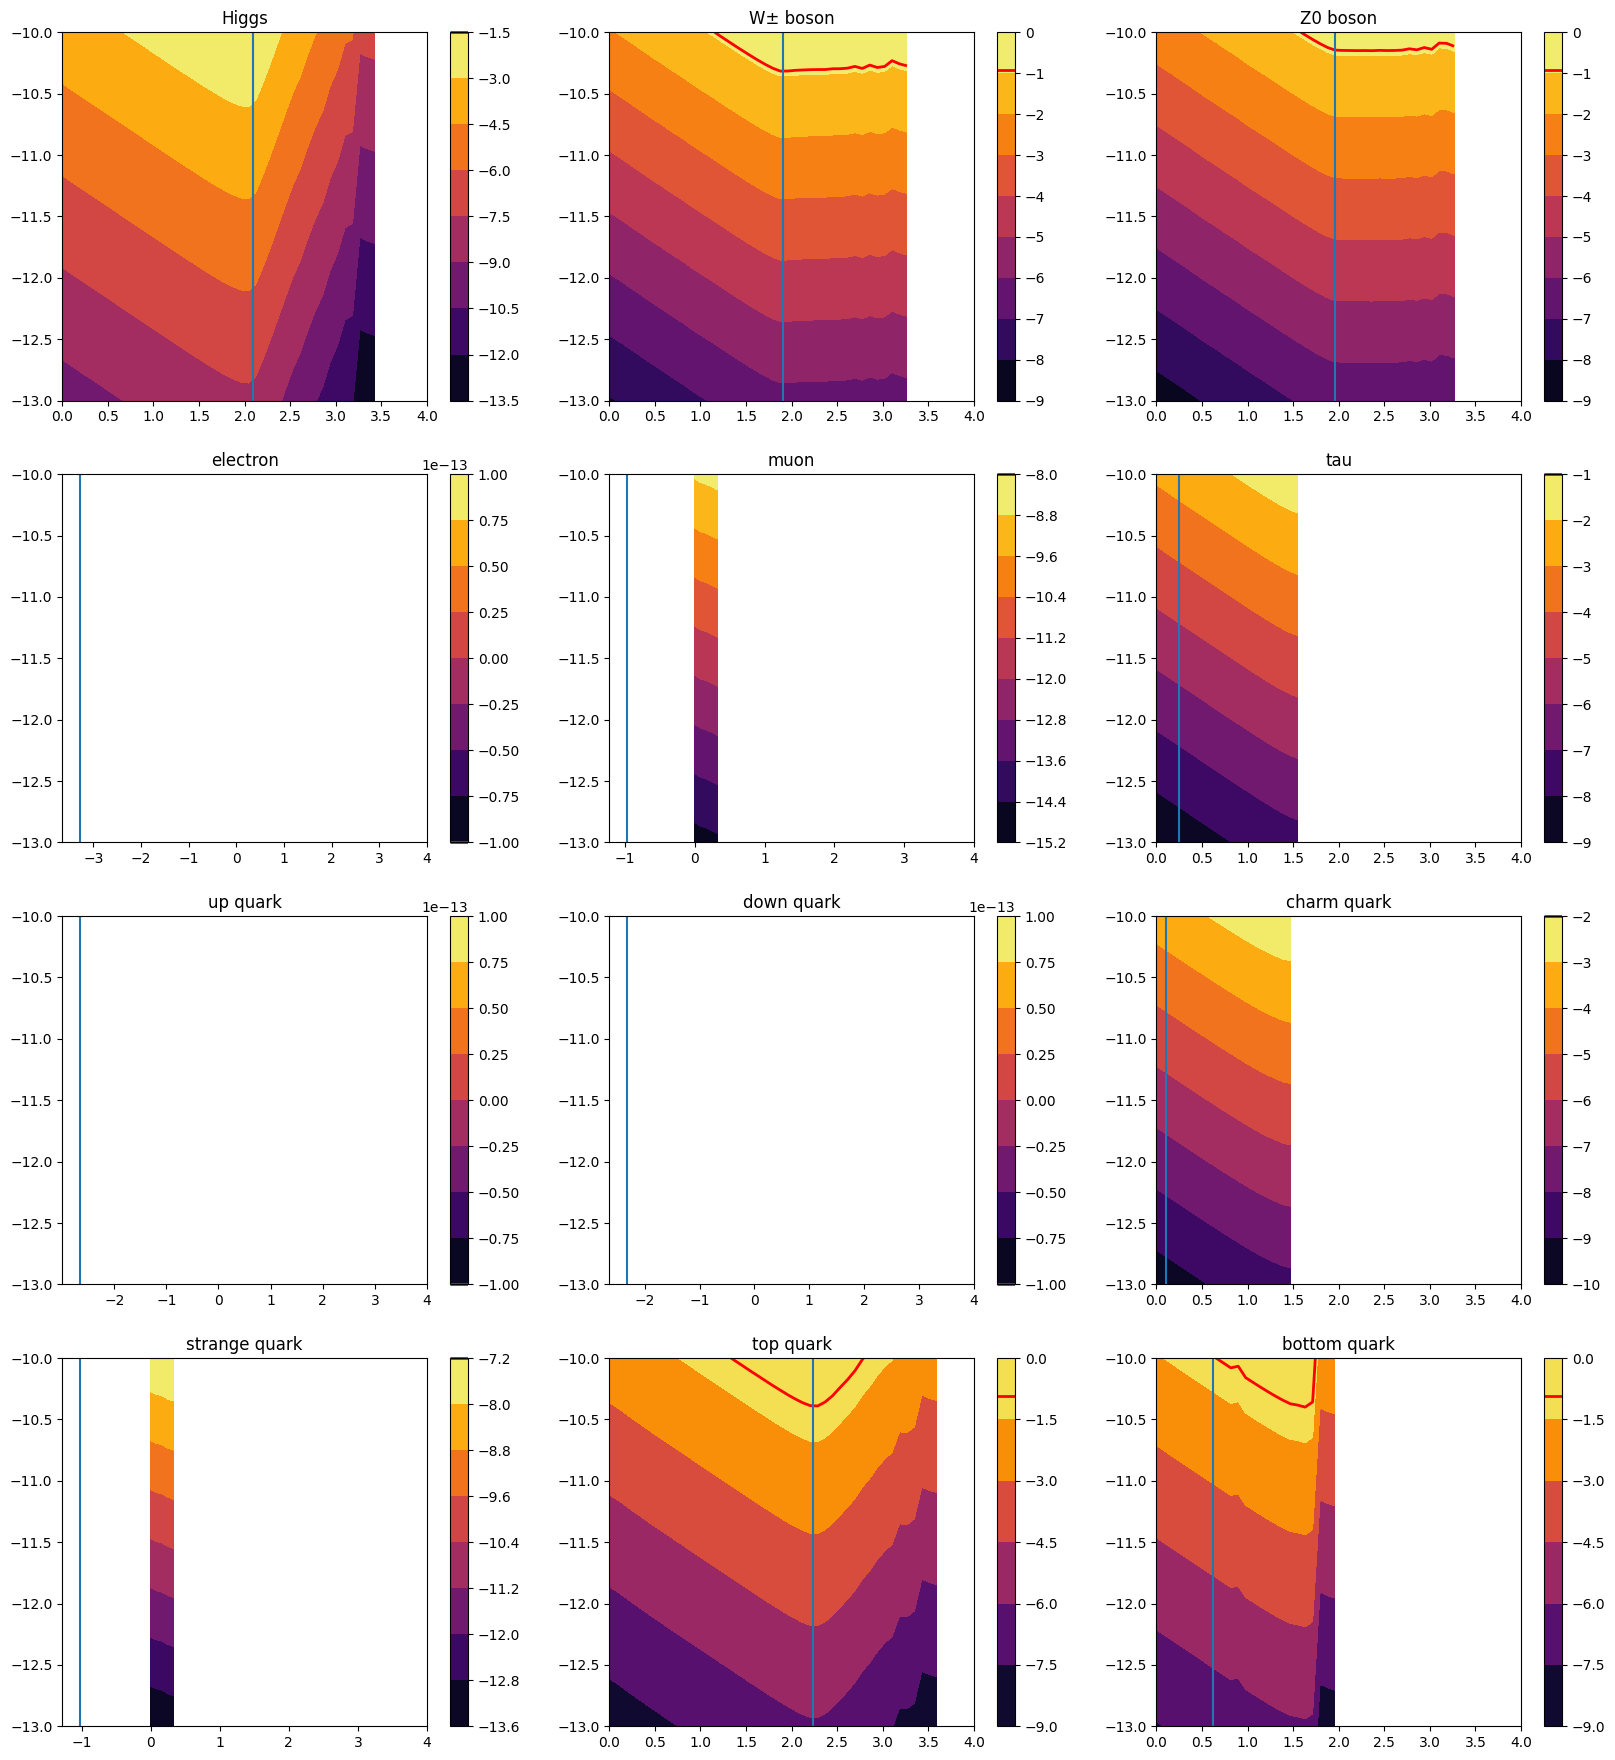

In [17]:
# Contours of abundance for Omegah2 with sigma_RE
fig, ax = plt.subplots(4,3,figsize=(20,22))
for i,part in enumerate(SM_particles.index):
    OO = Omegah2(MM,LL,1e12,part)
    CS = ax[i//3,i%3].contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)
    CSl = ax[i//3,i%3].contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
    ax[i//3,i%3].vlines(np.log10(SM_particles.loc[part]['mass']),-13,-10)
    cbar = fig.colorbar(CS)
    cbar.add_lines(CSl)
    ax[i//3,i%3].set(title=SM_particles.loc[part]['name'])
    print(SM_particles.loc[part]['name'] + ' completed')

In [14]:
# micromegas data
micromegas = pd.read_csv('params_micromegas.csv')

KeyboardInterrupt: 

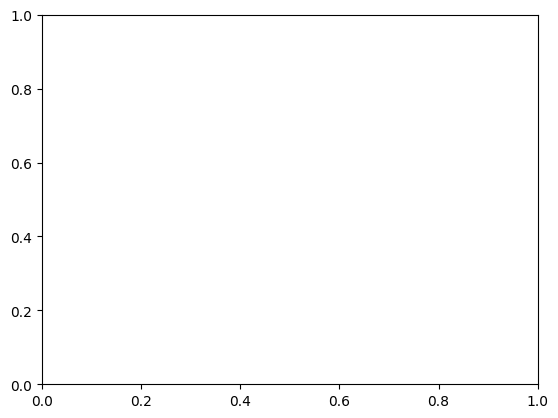

In [15]:
# plot sigma_abs
fig, ax = plt.subplots()
OO = Omegah2(MM,LL,1e6,'all')
CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
ax.plot(micromegas['M'],micromegas['lambda'],color = 'yellow',linestyle = '--')
ax.vlines(np.log10(SM_particles.loc['h']['mass']/2),-13,-10)
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)
ax.set(title=SM_particles.loc['h']['name'])
print(SM_particles.loc['h']['name'] + ' completed')

In [23]:
OO

array([[2.64104518e+54, 3.18711221e+54, 3.84604000e+54, 4.64112046e+54,
        5.60042655e+54, 6.75777405e+54, 8.15386182e+54, 9.83761179e+54,
        1.18677229e+55, 1.43144345e+55, 1.72614584e+55, 2.08079609e+55,
        2.50703396e+55, 3.01832680e+55, 3.62989922e+55, 4.35829325e+55,
        5.22018852e+55, 6.22976813e+55, 7.39321519e+55, 8.69739588e+55,
        1.00860747e+56, 1.14063439e+56, 1.22669718e+56, 1.14531520e+56,
        6.35767490e+55, 4.35160651e+55, 1.11009823e+55, 9.05602104e+54,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.22586458e+55, 1.47932644e+55, 1.78517363e+55, 2.15421729e+55,
        2.59948773e+55,

In [15]:
# a(T)
a_int = lambda lnT: (1+1/3*dlnheffdlnT(lnT))
scalefactor = lambda T: np.exp(quad(a_int,np.log(T),np.log(T0),limit=1000)[0])
scalefactor = np.vectorize(scalefactor)

/tmp/ipykernel_11357/362512069.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  scalefactor = lambda T: np.exp(quad(a_int,np.log(T),np.log(T0),limit=1000)[0])


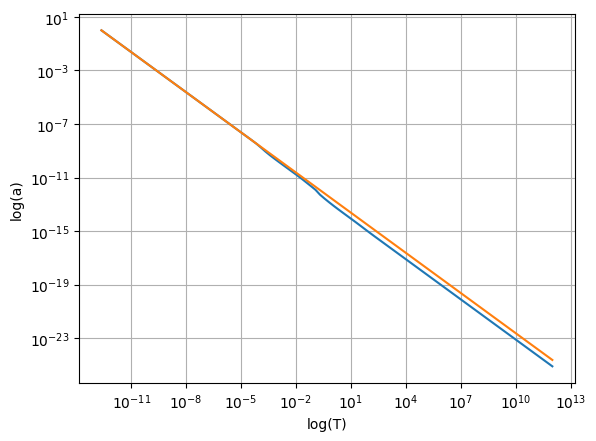

In [16]:
# a(T) graph

Ts = np.logspace(np.log10(T0),12,100)
a_s = scalefactor(Ts)

logT = lambda loga,m,b: m*loga+b

pars,_ = curve_fit(logT,np.log10(a_s),np.log10(Ts))

m_,b_ = pars

def temp(a):
    return 10**b_*a**m_

temp = np.vectorize(temp)

TR = 1e12
aTR = scalefactor(TR)

a_s2 = np.linspace(1,aTR)
Ts2 = temp(a_s2)

plt.loglog(Ts,a_s)
plt.loglog(Ts,T0/Ts)
plt.grid()
plt.xlabel('log(T)')
plt.ylabel('log(a)')
plt.show()

In [17]:
# T(a)
def temp(a):
    func = lambda lnT: quad(a_int,lnT,np.log(T0),limit=1000)[0]-np.log(a)
    lnT_sol = newton(func,1)
    return np.exp(lnT_sol)

temp = np.vectorize(temp)

$$
\langle\sigma v\rangle = \dfrac{1}{8m_X^4TK^2_2(m/T)}\int_{4m_X^2}^\infty\sigma(s-4m_X^2)\sqrt{s}K_1(\sqrt{s}/T)\mathrm{d}s
$$

In [18]:
# Thermally averaged cross section

def sigmav(a,part,M_S,lambda_HS):
    mX = SM_particles.loc[part]['mass']
    integrand = lambda w: sigma_RE(w,M_S,lambda_HS,part)*(4*mX**2*np.tan(w))**0.5*kn(1,(4*mX**2*np.tan(w))**0.5/temp(a))*4*mX**2/(np.cos(w)**2)
    I = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
    return I

sigmav = np.vectorize(sigmav)

$$Y_S(1)=\int_{a(T_R)}^1\mathrm{d}a\dfrac{a^2}{H}\left[\dfrac{T(a)}{32\pi^4}\int_{4M_S^2}^\infty\mathrm{d}s\displaystyle\sum_X c_Xg_X^2\sigma_{X\bar{X}\to SS}(s)(s-4m_X^2)\sqrt{s}K_1(\sqrt{s}/T(a))+\dfrac{g_hm_h^2T(a)}{2\pi^2}C\Gamma_{h\to SS}K_1(m_h/T(a))\right]$$

In [19]:
def omegah2_yield(M_S,lambda_HS,TR):
    aini = scalefactor(TR)
    def integrand_a(a):
        def integrand_s(s):
            suma = 0
            for part in SM_particles.index:
                Mx = SM_particles.loc[part]['mass']
                gx = SM_particles.loc[part]['dof']*SM_particles.loc[part]['n_c']
                cx = SM_particles.loc[part]['antiparticle']
                suma += cx*gx**2*sigma_s(s,M_S,lambda_HS,initial_particle=part)*(s-4*Mx**2)
            return suma*s**0.5*kn(1,s**0.5*a/T0)
        term1 = (T0/a)/(32*np.pi**4)*quad(integrand_s,4*M_S**2,np.inf,limit=100)[0]
        term2 = SM_particles.loc['h']['dof']*SM_particles.loc['h']['mass']**2*(T0/a)/(2*np.pi**2)*C*Gamma_hSS(lambda_HS,M_S)*kn(1,SM_particles.loc['h']['mass']*a/T0)

        H = 1/MP*(np.pi**2/90*geff(T0/a)*(T0/a)**4)**0.5
        return a**2/H*(term1+term2)
    integrand_a = np.vectorize(integrand_a)
    #Y = quad(integrand_a,aini,1,limit=100)[0]
    a_s = np.logspace(np.log10(aini),0,1000)
    return M_S*s0mo*integrand_a(a_s)

In [20]:
rhoc0mo

1.1151984914745777e-43

In [23]:
omegah2_yield(1,1e-9,1e6)

/tmp/ipykernel_54788/362512069.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  scalefactor = lambda T: np.exp(quad(a_int,np.log(T),np.log(T0),limit=1000)[0])


KeyboardInterrupt: 

In [21]:
def Boltz_eq(x,M_S,lambda_HS,channel):
    # HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
    # sMS = 2*np.pi**2/45*gstars0*M_S**3
    HMS = (np.pi**2*geff(M_S/x)/90)**0.5*M_S**2/MP
    sMS = 2*np.pi**2/45*heff(M_S/x)*M_S**3
    HMS = HMS/(1+(1/3)*dlnheffdlnT(np.log(M_S/x)))
    if channel == 'all':
        suma = 0
        for part in SM_particles.index:
            M = SM_particles.loc[part]['mass']
            g = SM_particles.loc[part]['dof']
            integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
            res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5,limit=100)[0]
            suma += (g**2/np.pi**4)*M_S*M**5/x*res
    
        return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
    elif channel == 'decay':
        return x**4/(HMS*sMS)*(C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
    else:
        M = SM_particles.loc[channel]['mass']
        g = SM_particles.loc[channel]['dof']
        n = SM_particles.loc[channel]['n_c']
        cx = SM_particles.loc[channel]['antiparticle']
        integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,channel)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
        res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5,limit=100)[0]
        term = ((g*n)**2*cx/np.pi**4)*M_S*M**5/x*res
        return x**4/(HMS*sMS)*term
    
Boltz_eq = np.vectorize(Boltz_eq)

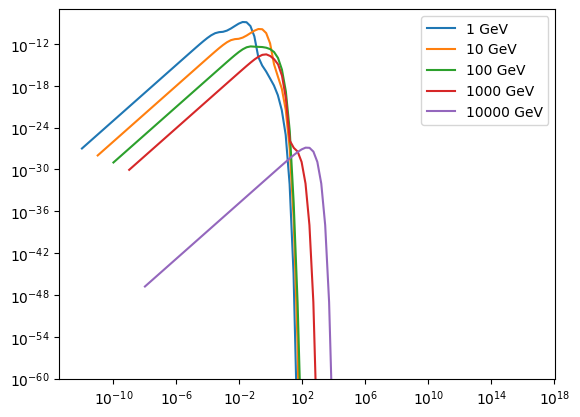

In [28]:
TR = 1e12
ms = [1,10,100,1000,10000]
lambdahs = 1e-11
for m in ms:
    xs = np.logspace(np.log10(m/TR),np.log10(m/T0),100)    
    funcs = Boltz_eq(xs,m,lambdahs,'all')
    plt.loglog(xs,funcs,label=f'{m} GeV')
    plt.ylim(1e-60,1e-7)
    plt.legend()

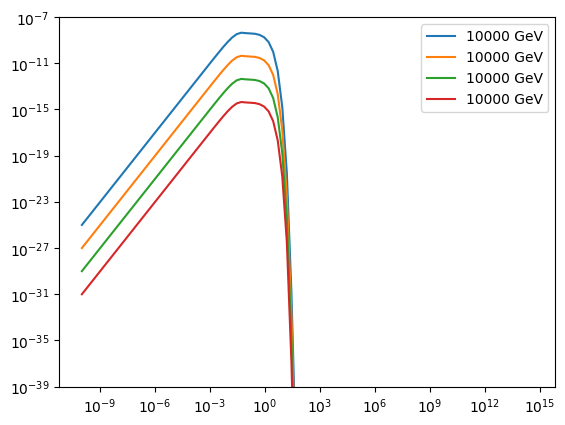

In [29]:
TR = 1e12
ms = 100
lambdahs = [1e-9,1e-10,1e-11,1e-12]
for l in lambdahs:
    xs = np.logspace(np.log10(ms/TR),np.log10(ms/T0),100)    
    funcs = Boltz_eq(xs,ms,l,'all')
    plt.loglog(xs,funcs,label=f'{m} GeV')
    plt.ylim(10e-40,1e-7)
    plt.legend()

*Por qué quad falla y qué se puede hacer*

quad usa aritmética de doble precisión y un algoritmo adaptativo de QUADPACK.
Cuando la función vale ≈ 10⁻⁹ pero el intervalo abarca 26 órdenes de magnitud, el integrador:

* *submuestrea* la zona donde el integrando todavía es apreciable; termina evaluándolo casi siempre donde ya es \~0 y “cree” que la integral es mayor de lo que es.
* *pierde dígitos* cuando suma contribuciones de magnitudes muy distintas (cancelación y redondeo).
  Esto produce sobre-/sub-estimaciones, como han documentado otros usuarios de SciPy ([stackoverflow.com][1]).

---

## Estrategias recomendadas

| Estrategia                                  | Idea clave                                                                                                                                                                   | Cuándo conviene                                                                      |
| ------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| *1. Cambio de variable logarítmico*       | Sustituya x = eᵗ (o 10ᵗ). El intervalo [10⁻¹⁰, 10¹⁶] se convierte en t ∈ [−23.0, 36.8] → rango finito y estable. Recuerde multiplicar por el jacobiano dx = eᵗ dt. | Siempre que la función sea suave en log(x); minimiza el rango dinámico.            |
| *2. Integración por tramos*               | Calcule la integral en subintervalos donde la función no sea despreciable (p. ej. divida en potencias de 10 con np.logspace) y sume los resultados.                        | Cuando existe un “pico” claro y colas rápidas. Ayuda a quad a enfocar.             |
| *3. Ajustar tolerancias de quad*        | Use epsabs, epsrel muy estrictos (p. ej. 1e-12) y aumente limit (n.º de subintervalos). Añada points=breakpoints si usa Estrategia 2.                              | Cuando mantiene doble precisión, pero necesita más muestreos.  ([docs.scipy.org][2]) |
| *4. Trabajar en log-espacio*              | Integre log(f(x)) con un trapecio adaptado que opera con log-suma-exp para evitar underflow ([math.stackexchange.com][3]).                                                 | Si f llega a < 1e-300 donde doble precisión se desborda.                           |
| *5. Precisión arbitraria (mpmath)*      | mpmath.quad permite fijar mp.dps a 50, 100… dígitos y manejar colas muy largas sin pérdida de precisión ([mpmath.org][4], [stackoverflow.com][5]).                       | Cuando se necesita más que 15-16 dígitos o la función es extremadamente pequeña.     |
| *6. Métodos de importancia / Monte Carlo* | Muestree según una distribución que se parezca a la función y promedie f(x)/p(x).                                                                                          | Último recurso para integrales muy irregulares o de alta dimensión.                  |

---

## Ejemplos de código

### 1. Cambio a variable logarítmica + quad

python
import numpy as np
from scipy.integrate import quad

def f(x):
    # ejemplo: f(x) = x**-1.1 * np.exp(-x)
    return x**-1.1 * np.exp(-x)

# transformamos x = exp(t)
def f_log(t):
    x = np.exp(t)
    return f(x) * np.exp(t)          # jacobiano dx = e^t dt

a, b = np.log(1e-10), np.log(1e16)
I, err = quad(f_log, a, b, epsabs=1e-12, epsrel=1e-10, limit=500)
print(I, err)


### 2. Precisión arbitraria con mpmath

python
import mpmath as mp

mp.dps = 60          # 60 dígitos decimales
f = lambda x: x**-1.1 * mp.e**(-x)
I = mp.quad(f, [1e-10, mp.inf])      # rango semiinfinito sin problema
print(I)


### 3. Integración por tramos con puntos sugeridos

python
breaks = np.logspace(-10, 16, 30)
I = 0.0
for lo, hi in zip(breaks[:-1], breaks[1:]):
    I += quad(f, lo, hi, epsabs=1e-12, epsrel=1e-10)[0]
print(I)


---

## Consejos prácticos

1. *Localice la zona útil* (donde f(x) > 10⁻¹⁶) y concentre la malla ahí.
2. *Normalice la función* si puede (escale f por una constante grande, integre y des-escale).
3. *Analice la cola*: si para x > x₀ conoce una aproximación analítica (p. ej. \~ A x^{-p} e^{-q x}), integre esa cola simbólicamente y añádala aparte: reduce trabajo numérico.
4. *Verifique con dos métodos* (p. ej. quad + mpmath) y compruebe que coincidan dentro del error requerido.

Con estos ajustes quad suele converger, y si no, mpmath le dará un resultado fiable (más lento, pero robusto).

[1]: https://stackoverflow.com/questions/63787530/how-to-calculate-integral-for-very-very-small-y-values-scipy-quad?utm_source=chatgpt.com "How to calculate integral for very very small y values (SciPy quad)"
[2]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html?utm_source=chatgpt.com "quad — SciPy v1.15.3 Manual"
[3]: https://math.stackexchange.com/questions/451771/how-to-numerically-integrate-expression-using-its-log-transform?utm_source=chatgpt.com "How to numerically integrate expression using its log transform"
[4]: https://mpmath.org/doc/current/calculus/integration.html?utm_source=chatgpt.com "Numerical integration (quadrature) — mpmath 1.3.0 documentation"
[5]: https://stackoverflow.com/questions/39515582/scipy-integrate-quad-precision-on-big-numbers?utm_source=chatgpt.com "python - scipy.integrate.quad precision on big numbers - Stack Overflow

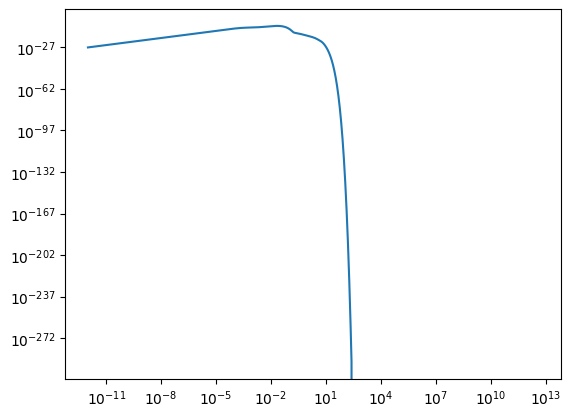

In [27]:
plt.loglog(xs,funcs)